In [1]:
import requests
from newspaper import Article, ArticleException
from bs4 import BeautifulSoup
from dateutil.rrule import *
from datetime import *
from textblob import TextBlob
import nltk
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# NOTE: this part of the program will take several hours to run, if you wish to skip running it,
# just grab my combined.csv file

def get_articles(dates):
    news_sites = ['foxnews.com', 'cnn.com', 'abcnews.go.com']
    data = []

    for site in news_sites:
        
        # loop through each set of dates you wish to input
        for date1, date2 in dates:
            articles = []
            
            # URL of the Google News rss
            # Consider changing the parameters at the end of this string if you search outside USA
            main_url = "https://news.google.com/rss/search?q=joe+biden+after:" + date1 + "+before:" + 
                date2 + "+site:" + site + "&ceid=US:en&hl=en-US&gl=US"
            
            # get the results in the rss and collect the links
            response = requests.get(main_url)
            webpage = response.content
            soup = BeautifulSoup(webpage, features="xml")
            items = soup.find_all('item')
            for item in items:
                link = item.find('link').text
                articles.append(link)

            # parse the articles and get the polarity and subjectivity scores for each in your 
            # specified time frame
            for url in articles:
                # print(url)
                # We throw this in a try/except block in case we get a bad link which would kill the program
                try:
                    article = Article(url)
                    article.download()
                    article.parse()
                    article.nlp()

                    title = article.title
                    text = article.text

                    # run sentiment analysis on the article text
                    # create a Textblob object and then get the sentiment values and store them
                    text_blob = TextBlob(text)
                    polarity = text_blob.polarity
                    subjectivity = text_blob.subjectivity

                    # Save the necessary data to then put in a csv file, the date can be set however you please
                    save = [site, url, title, datetime.strptime(date2, "%Y-%m-%d").strftime('%b %Y'), polarity, subjectivity]
                                        
                    # to make sure that the article does include Joe Biden
                    # depending on your criteria, Google will often give you completely irrelevant results 
                    # in the rss
                    if 'Biden' in text:
                        # in case we get a non-article as a link - do not include in data 
                        # (this does happen once in a while)
                        if polarity == 0 and subjectivity == 0:
                            pass
                        else:
                            data.append(save)
                
                # If there is a bad link, move on to the next one
                except ArticleException:
                    pass

    return(data)

SyntaxError: invalid syntax (<ipython-input-2-699c664bd293>, line 16)

In [ ]:
# I use dateutil to set the timeframe - I pull articles at monthly intervals staring from 9/2020 to 8/2021
start_dates = [datetime.strftime(dt, "%Y-%m-%d") for dt in rrule(MONTHLY, dtstart=datetime(2020, 9, 1), until=datetime(2021, 8, 1))]
end_dates = [datetime.strftime(dt, "%Y-%m-%d") for dt in rrule(MONTHLY, dtstart=datetime(2020, 9, 30), bymonthday=(31, -1), bysetpos=1, until=datetime(2021, 8, 31))]
dates_list = list(zip(start_dates, end_dates))

articles = get_articles(dates_list)

In [3]:
# write data to csv
with open('combined.csv', 'w') as csv_file:
    header = ['News Source', 'URL', 'Title', 'Month', 'Polarity', 'Subjectivity']
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(articles)
    csv_file.close()

NameError: name 'articles' is not defined

In [4]:
# set the dataframe, convert the date column from a string, and then sort so the data is plotted correctly
df = pd.read_csv('combined.csv')
df['Month'] = pd.to_datetime(df['Month']).dt.strftime("%Y-%m")
df.sort_values(by=['Month', 'News Source'], inplace=True)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

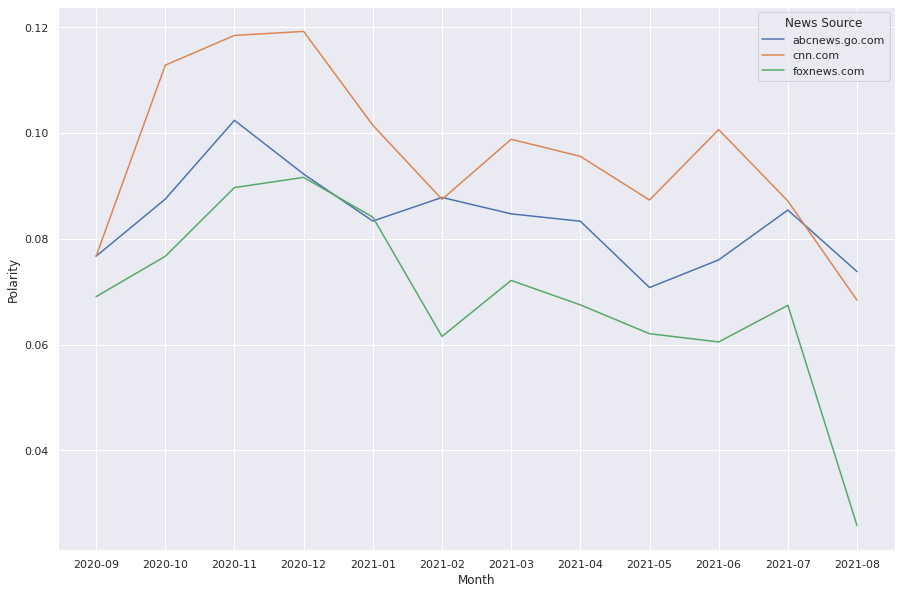

In [8]:
# line chart of the average polarity per month for each source
# I use seaborn because I found it to be the easiest for me to use
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x = 'Month', y = 'Polarity', hue='News Source', ci=None, data = df)

<AxesSubplot:xlabel='Month', ylabel='Subjectivity'>

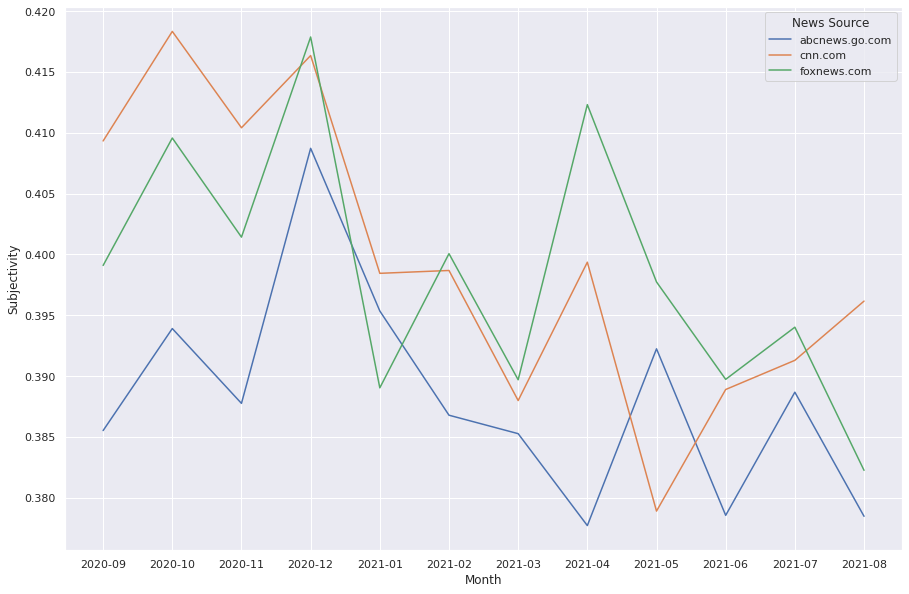

In [7]:
# line chart of the average subjectivity per month for each source
sns.lineplot(x = 'Month', y = 'Subjectivity', hue='News Source', ci=None, data = df)

<AxesSubplot:xlabel='Polarity', ylabel='Month'>

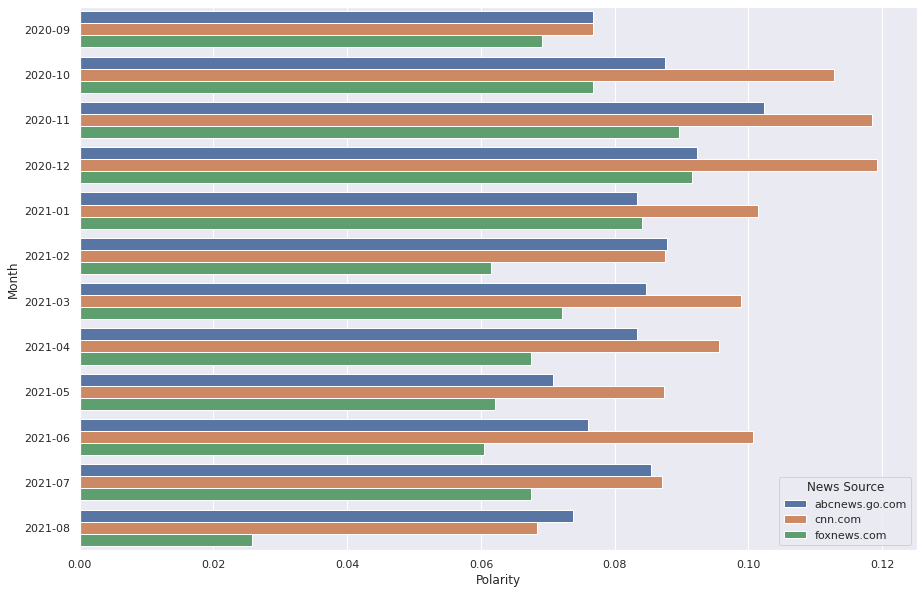

In [6]:
# bar chart of the average polarity per month for each source
sns.barplot(y = 'Month', x = 'Polarity', hue='News Source', ci=None, data = df)

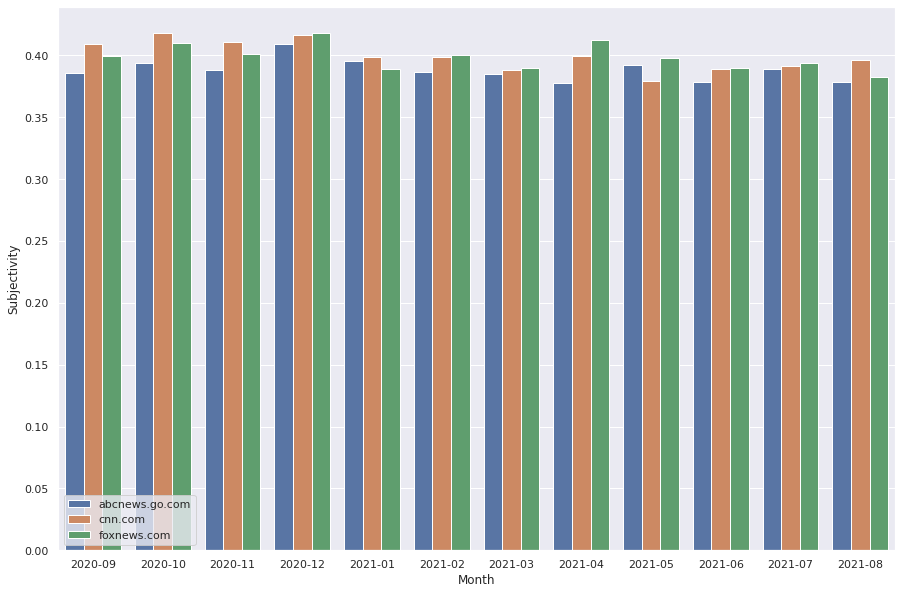

In [9]:
# bar chart of the average subjectivity per month for each source
sns.barplot(x = 'Month', y = 'Subjectivity', hue='News Source', ci=None, data = df)
plt.legend(loc='lower left')

<AxesSubplot:xlabel='News Source', ylabel='Polarity'>

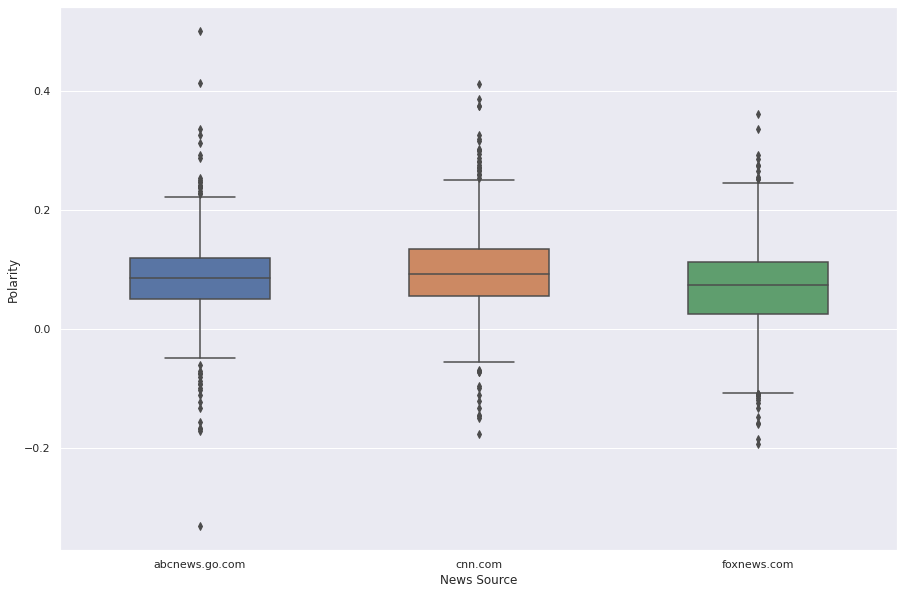

In [10]:
# box plot of all of the news sites together
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x = 'News Source', y = 'Polarity', data = df, width=.5)


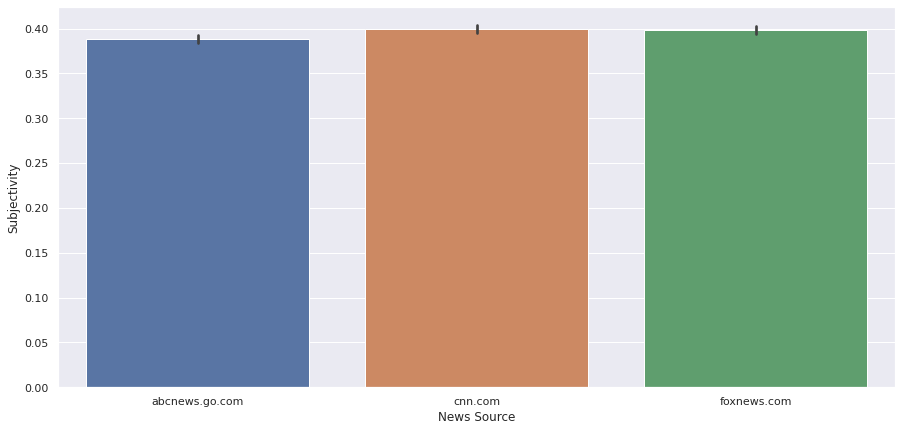

In [11]:
# box plot of all of the news sites together
sns.set(rc={'figure.figsize':(15,7)})
sns.barplot(x = 'News Source', y = 'Subjectivity', data = df)

plt.show()

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

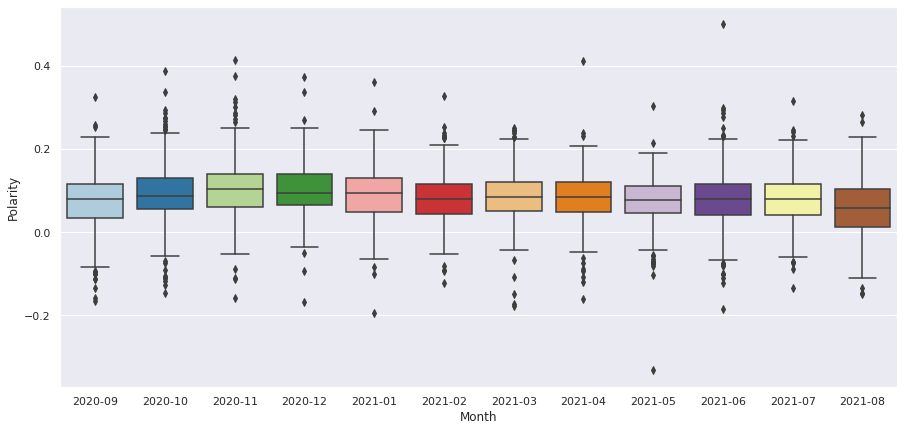

In [12]:
# box plot of all of the news sites together, records by month
sns.boxplot(x = 'Month', y = 'Polarity', data = df, palette="Paired")

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

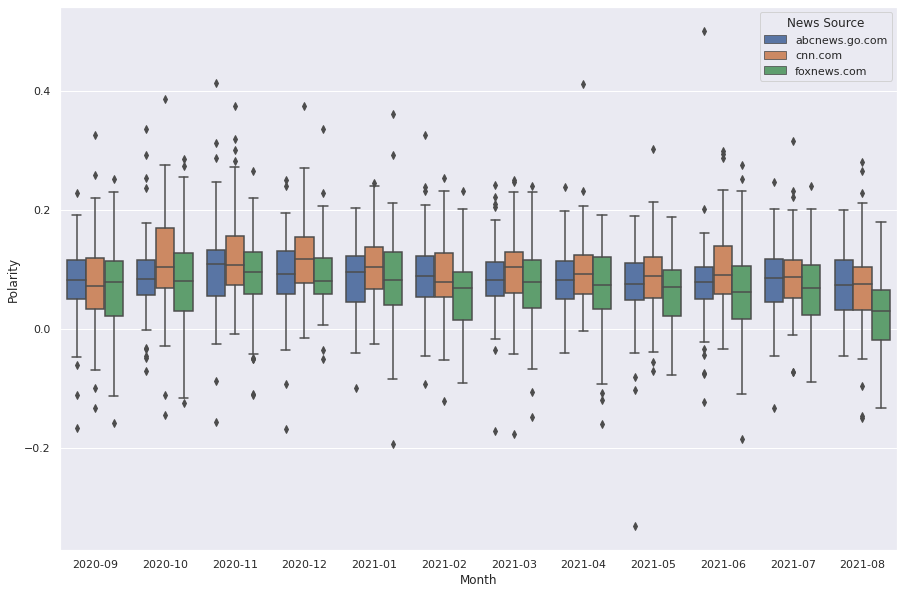

In [13]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x = 'Month', y = 'Polarity', hue = 'News Source', data = df)

<AxesSubplot:xlabel='Month', ylabel='Subjectivity'>

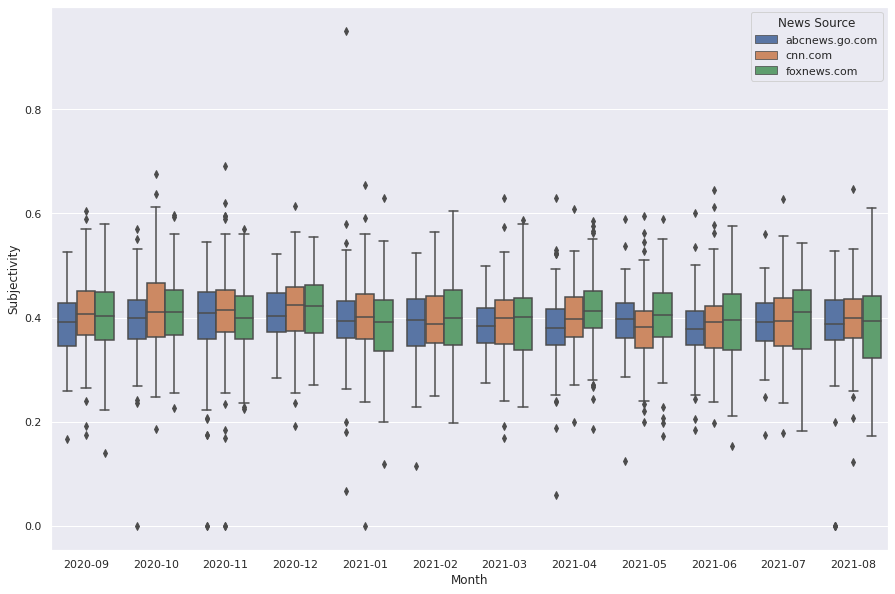

In [14]:
sns.boxplot(x = 'Month', y = 'Subjectivity', hue = 'News Source', data = df)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

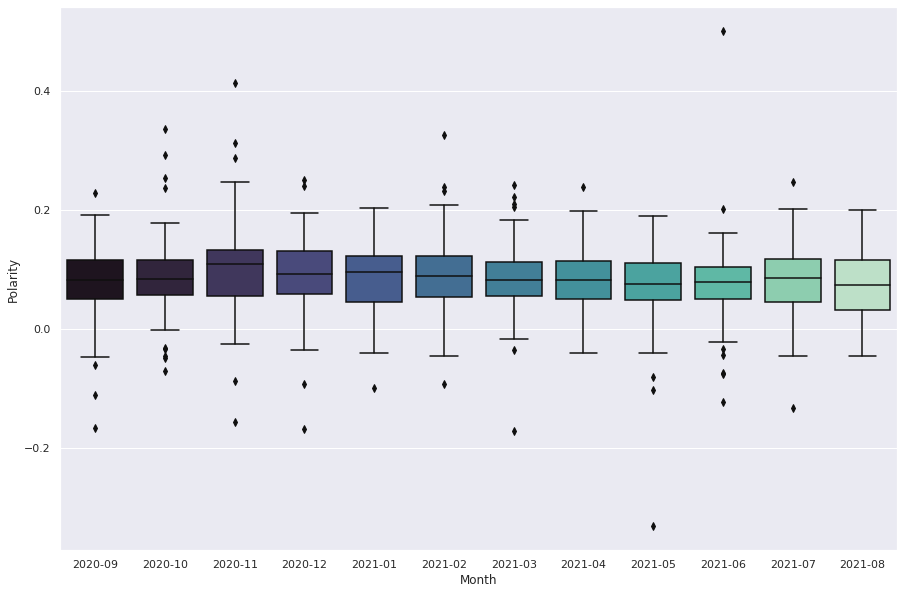

In [15]:
abc = df.groupby(['News Source']).get_group('abcnews.go.com')
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x = 'Month', y = 'Polarity', data = abc, palette='mako')

<AxesSubplot:xlabel='Month', ylabel='Subjectivity'>

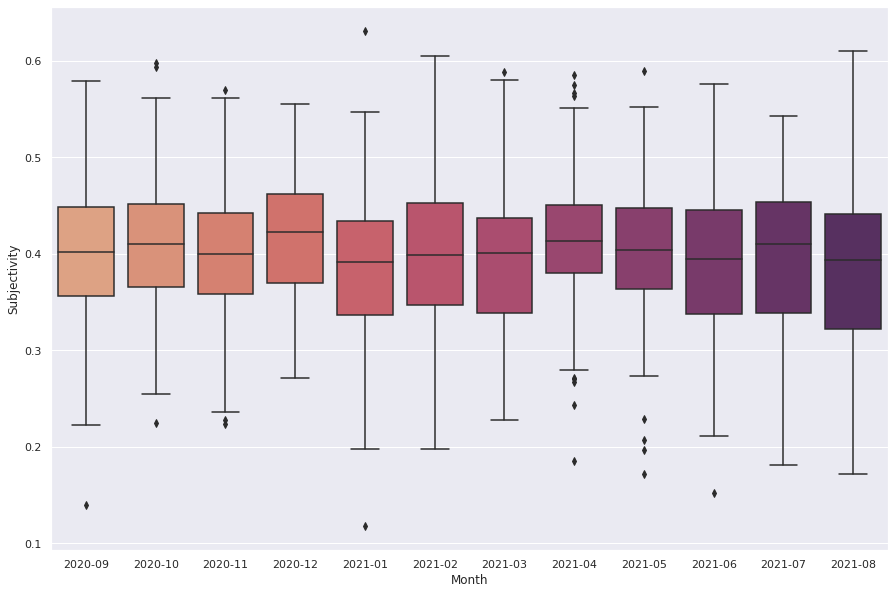

In [16]:
fox = df.groupby(['News Source']).get_group('foxnews.com')
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x = 'Month', y = 'Subjectivity', data = fox, palette='flare')